In [1]:
import sys
sys.path.append('auto_encoder//')
sys.path.append('classificator//')

import model_autoencoder
import model_classificator
import torch
import dlib
import cv2
import matplotlib.pyplot as plt
from imutils import face_utils
import numpy as np

In [2]:
restore_classificator='classificator//classificator_'
restore_autoencoder='auto_encoder//finnaaal_for_blue_eyes'

START_COORD=np.array([[143.5    , 154.     ],
       [212.33333, 155.     ],
       [182.38889, 232.05556]], dtype=np.float32)

In [3]:
classificator = model_classificator.Net()
classificator.load_state_dict(torch.load(restore_classificator, map_location='cpu' ))

In [4]:
autoencoder = model_autoencoder.Net()
autoencoder.load_state_dict(torch.load(restore_autoencoder, map_location='cpu' ))

In [5]:
def preprocess(img):
    im=torch.tensor(np.array(img,np.float32))
    im=(im-127.5)/127.5
    return im.permute(2,0,1)
    

In [78]:
def read_image(path):
    return cv2.imread(path)[:,:,::-1]
def get_faces(img,face_detector):
    image = img
    detected_faces = face_detector(image, 1)
    return detected_faces

In [147]:
def get_pts(ff):
    ax=np.mean(ff[:,0][36:42])
    ay=np.mean(ff[:,1][36:42])
    axx=np.mean(ff[:,0][42:48])
    ayy=np.mean(ff[:,1][42:48])
    
    axxx=np.mean(ff[:,0][50:68])
    ayyy=np.mean(ff[:,1][50:68])
    return np.array([[ax,ay],[axx,ayy],[axxx,ayyy]],np.float32)
def get_shape(image,detect1,predictor1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detector = detect1
    predictor = predictor1
    rects = detector(gray)
    rect=rects[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    return np.float32(shape),image
def rotate_image(img,detect1,predictor1):
    try:
        pp,immg = get_shape(img,detect1,predictor1)
        if len(pp)==68:
            matrix_rotation = cv2.getAffineTransform(get_pts(pp),START_COORD)
            res=cv2.warpAffine(immg,matrix_rotation,(700,700))
            q=np.copy(res)
            cv2.circle(res,(143,154), 15, (255,0,0), -1)
            cv2.circle(res,(212,155), 15, (255,0,0), -1)

            return [res,q,matrix_rotation]
        else:
            print(imgg,'Not enough points')
    except Exception as e:
        print('Problems with eyes detection ',e)

In [148]:
def facess(im):
    detect1= dlib.get_frontal_face_detector()
    predictor1 = dlib.shape_predictor('shape_predictor\\shape_predictor_68_face_landmarks.dat')
    img = im
    rect =get_faces(img,detect1)
    if len(rect)==0:
        return 'Not find faces'
    mas = []
    r=rect[0]
    for r in rect:
        middle=np.mean(START_COORD,axis=0)
        top,bottom,left,right=r.top(),r.bottom(),r.left(),r.right()
        img_encoder,img_classificate,matrix=rotate_image(img[top:bottom,left:right],detect1,predictor1)
        #---------
        w=np.where(img_encoder!=0)
        xl,yl,xr,yr=(min(w[0]),min(w[1]),max(w[0]),max(w[1]))
        #---------
        mas.append([img_encoder[xl:xr,yl:yr],img_classificate[xl:xr,yl:yr],matrix,(xl,yl,xr,yr),img[top:bottom,left:right].shape,(top,bottom,left,right)])
    return mas
def classificate(img):
    classificator.eval()
    return classificator(preprocess(img).unsqueeze(0).float())
def autoencode(img):
    autoencoder.train()
    return np.array((autoencoder(preprocess(img).unsqueeze(0).float())[0].detach().permute(1,2,0)*127.5)+127.5,dtype=int)
def invertBack(img,matrix):
    return cv2.warpAffine(img,cv2.invertAffineTransform(matrix),(700,700))
def get_back_image(maxes,im,matrix,shapes):
    mas=np.zeros((700,700,3),dtype=np.uint8)
    (xl,yl,xr,yr)=maxes
    mas[xl:xr,yl:yr,:]=im
    return invertBack(mas,matrix)[:shapes[0],:shapes[1]]

In [149]:
def all_in(path):
    im =read_image(path)
    faces=facess(im)
    for w in faces:
        try:
            score = classificate(w[1])
            
            img_encoder = autoencode(w[0])
            img_back=get_back_image(w[-3],img_encoder,w[-4],w[-2])
            top,bottom,left,right=w[-1]
            im[top:bottom,left:right]=img_back
            im=cv2.rectangle(im.astype(np.int32), (left, top), (right, bottom), (255, 255, 0), 2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(im,str(score[0][0].item())[:4],(left,top), font, 1,(255,0,0),2,1)
        except Exception as e:
            print('Problems ',e)
    return im

In [165]:
res = all_in('images\\closedd.jpg')

C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [166]:
cv2.imwrite('C:\\Users\\ADMIN\\Desktop\\imm2.jpg',res[:,:,::-1])

True

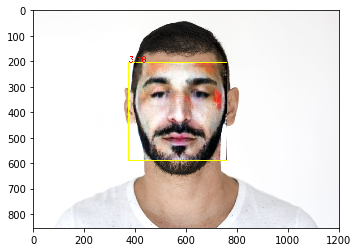

In [164]:
plt.imshow(res)

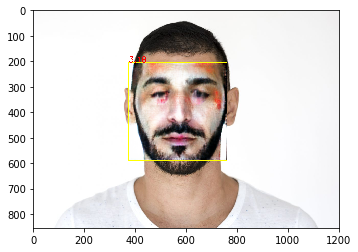

In [96]:
plt.imshow(res)

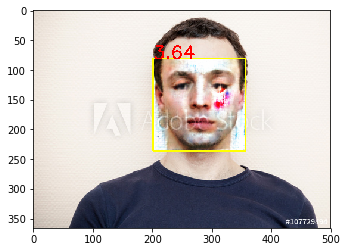

In [125]:
plt.imshow(res)

In [47]:
w=facess('images\\img.jpg')

In [10]:
import torch.nn
def compute_saliency_maps(X, y, model):
    criterion = torch.nn.MSELoss()
    model.eval()
    X.requires_grad_(True)    
    
    outputs = model(X)
    
    loss = criterion(outputs, y)
    
    loss.backward()
    
    saliency = X.grad.data.abs()
    saliency=torch.max(saliency,1)[0]
    return saliency

In [11]:
y=torch.tensor(np.array([[1.016667,4.75]],dtype=np.float32))
x=torch.stack([preprocess(cv2.imread('images//'+'AF1986.jpg')[:,:,::-1]),preprocess(cv2.imread('images//'+'AF1973.jpg')[:,:,::-1])],dim=0)
saliency=compute_saliency_maps(x,y.float(),classificator)

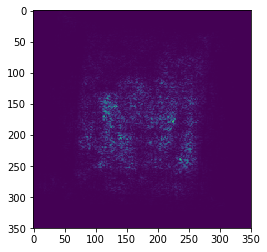

In [12]:
plt.imshow(saliency[0])

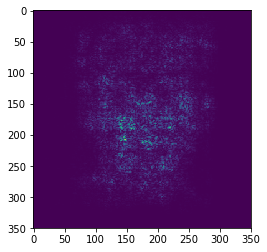

In [13]:
plt.imshow(saliency[1])

In [12]:
def make_fooling_image(X, target_y, model):
    model.eval()
    criterion = torch.nn.MSELoss()
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_(True)
    norm=0
    learning_rate = 1
    it=0
    while it<30:
        outputs = model(X_fooling)
        loss = criterion(outputs, torch.tensor([target_y]))
        loss.backward()
        X_fooling.data=X_fooling.data-learning_rate*X_fooling.grad.data/torch.norm(X_fooling.grad.data)
        it+=1
        print(torch.sum((outputs-target_y)**2),it)
        if torch.sum((outputs-target_y)**2)<1:
            break;

    return X_fooling

In [14]:
fool = make_fooling_image(preprocess(cv2.resize(cv2.imread('images//'+'mykola.jpg')[:,:,::-1],(350,350))).unsqueeze(0),torch.tensor(np.array([[7]],dtype=np.float32)),classificator)

tensor(19.7939, grad_fn=<SumBackward0>) 1
tensor(16.3436, grad_fn=<SumBackward0>) 2
tensor(13.5092, grad_fn=<SumBackward0>) 3
tensor(11.4804, grad_fn=<SumBackward0>) 4
tensor(10.1075, grad_fn=<SumBackward0>) 5
tensor(9.0979, grad_fn=<SumBackward0>) 6
tensor(8.2861, grad_fn=<SumBackward0>) 7
tensor(7.6049, grad_fn=<SumBackward0>) 8
tensor(7.0123, grad_fn=<SumBackward0>) 9
tensor(6.4924, grad_fn=<SumBackward0>) 10
tensor(6.0264, grad_fn=<SumBackward0>) 11
tensor(5.5928, grad_fn=<SumBackward0>) 12
tensor(5.1840, grad_fn=<SumBackward0>) 13
tensor(4.8100, grad_fn=<SumBackward0>) 14
tensor(4.4588, grad_fn=<SumBackward0>) 15
tensor(4.1291, grad_fn=<SumBackward0>) 16
tensor(3.8143, grad_fn=<SumBackward0>) 17
tensor(3.5172, grad_fn=<SumBackward0>) 18
tensor(3.2368, grad_fn=<SumBackward0>) 19
tensor(2.9752, grad_fn=<SumBackward0>) 20
tensor(2.7355, grad_fn=<SumBackward0>) 21
tensor(2.5136, grad_fn=<SumBackward0>) 22
tensor(2.3089, grad_fn=<SumBackward0>) 23
tensor(2.1187, grad_fn=<SumBackward0>)

In [15]:
classificator(fool)

tensor([[5.9429]], grad_fn=<AddmmBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


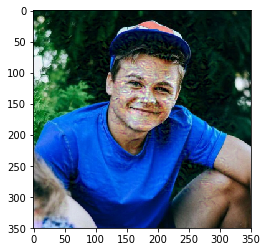

In [32]:
plt.imshow(np.array(fool.squeeze().permute(1,2,0).detach().numpy()*127.5+127.5,dtype=np.int))

In [24]:
fool.squeeze().permute(1,2,0).size()

torch.Size([350, 350, 3])

In [33]:
cv2.imwrite('C:\\Users\\ADMIN\\Downloads\\mukola.jpg',np.array(fool.squeeze().permute(1,2,0).detach().numpy()*127.5+127.5,dtype=np.int)[:,:,::-1])

True

In [20]:
import numpy as np

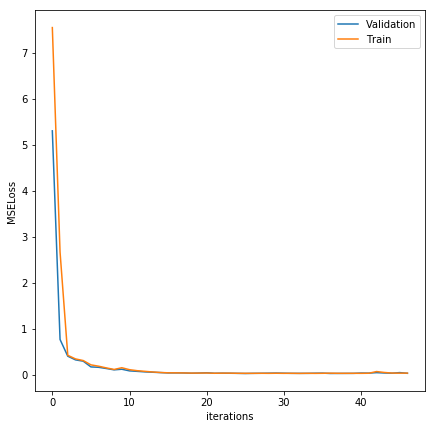

In [62]:
plt.figure(figsize=(7,7))
plt.plot(np.loadtxt('C:\\Users\\ADMIN\\Downloads\\classificator(31.08.19)\\test.txt'),label='Validation')
plt.xlabel('iterations')
plt.ylabel('MSELoss')
plt.plot(np.loadtxt('C:\\Users\\ADMIN\\Downloads\\classificator(31.08.19)\\train.txt'),label='Train')
plt.legend()


In [63]:
preprocess(cv2.imread('C:\\Users\\ADMIN\\Desktop\\projectFacesss\\img_circle\\CM750.jpg')[:,:,::-1])
autoencoder(torc)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [70]:
X=torch.stack([preprocess(cv2.imread('C:\\Users\\ADMIN\\Desktop\\projectFacesss\\img_circle\\CM750.jpg')[:,:,::-1]),preprocess(cv2.imread('C:\\Users\\ADMIN\\Desktop\\projectFacesss\\img_circle\\CM747.jpg')[:,:,::-1]),preprocess(cv2.imread('C:\\Users\\ADMIN\\Desktop\\projectFacesss\\img_circle\\CM748.jpg')[:,:,::-1])])

In [72]:
y=autoencoder(X)

C:\Users\ADMIN\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [73]:
def decode(img):
    img=img.permute(1,2,0).detach()
    return np.array(img*127.5+127.5,dtype=int)

In [75]:
for i in range(3):
    cv2.imwrite('C:\\Users\\ADMIN\\Desktop\\im'+str(i)+'.jpg',decode(y[i])[:,:,::-1])